In [199]:
# install packages


# import packages

import pandas as pd
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
#hmm
from hmmlearn import hmm



# format

# def stock_data(stock_name -> str):

# Return train_data, test_data 


# def  model_function(train_data -> np.array, num_of_predictions -> int):

# 	Return prediction 


# def evaluation(test_data -> np.array, prediction -> np.array):
	
# 	Return metrics


# pick stocks

In [84]:
# load and group by cap size
stocks_screener = pd.read_csv('nasdaq_screener_1637428146284.csv') #https://www.nasdaq.com/market-activity/stocks/screener
stocks_screener = stocks_screener[stocks_screener['Market Cap'].notna()]

M = 10**6
B = 10**9

bins =  np.array([0,50*M,300*M,2*B,10*B,200*B,np.inf])
ind = np.digitize(stocks_screener['Market Cap'], bins)

stocks_screener['Cap Group'] = ind

gb = stocks_screener.groupby('Cap Group')
list_of_groupbed_stocks = [gb.get_group(x) for x in gb.groups]

cap_list = ['nano','micro','small','medium','large','mega']
stock_cap_dict = dict()
for i in range(len(cap_list)):
    stock_cap_dict[cap_list[i]] = list_of_groupbed_stocks[i]['Symbol']
    


In [85]:
# def stock_picker(stock_dict = stock_cap_dict,cap = 'small',num_stocks = 100):
    
#     ticker_list = list((stock_dict[cap]).sample(n=num_stocks))

#     return ticker_list

In [86]:
# sample = stock_picker(cap = 'large',num_stocks = 10)
# sample

In [87]:
# def ticker_to_data(ticker = 'aapl',want_log = True):
#     stock_data = yf.download(ticker, start="2018-01-01", end="2021-12-31").reset_index()
#     stock_data['daily_return'] = (stock_data.Close /
#         stock_data.Close.shift(-1)).dropna()
    
#     stock_data['Log_daily_return'] = np.log(stock_data['daily_return'])
    
#     train_full, test_full = stock_data[stock_data.Date<'2021-01-01'],stock_data[stock_data.Date>='2021-01-01']
    
#     print(ticker)
#     print(len(train_full))
#     print(len(test_full))
#     if want_log:    
#         train_close,test_close = np.array(train_full.Log_daily_return),np.array(test_full.Log_daily_return)
#     else:
#         train_close,test_close = np.array(train_full.daily_return),np.array(test_full.daily_return)
#     return train_close,test_close,stock_data

In [188]:
def pick_stock_get_data(stock_dict = stock_cap_dict,cap = 'small',num_stocks = 100,want_log = True,start_date="2018-01-01",
                        end_date="2021-12-31",cut_date = '2021-01-01' ):
    
    #length standards
    stock_data = yf.download('AAPL', start=start_date, end=end_date,progress=False).reset_index()
    standard_length = len(stock_data)
    
    count = 0
    
    resample_count = 0
    
    train_data = {}
    test_data = {}
    
    while count<num_stocks:
        
        length = 0
        
        resample_count-=1
        
        while length!=standard_length:
            resample_count+=1
            stock_sample =  list((stock_dict[cap]).sample(n=1))[0]
            stock_data = yf.download(stock_sample, start=start_date, end=end_date,progress = False).reset_index()
            length = len(stock_data)
        
        
        stock_data['daily_return'] = (stock_data.Close /stock_data.Close.shift(-1)).dropna()
        
        stock_data['Log_daily_return'] = np.log(stock_data.Close /stock_data.Close.shift(-1).dropna())
        
        train_full, test_full = stock_data[stock_data.Date<cut_date],stock_data[stock_data.Date>=cut_date]
        
        if want_log:
        
            train_data[stock_sample],test_data[stock_sample] = np.array(train_full.Log_daily_return),np.array(test_full.Log_daily_return.dropna())
            
        else:
            
            train_data[stock_sample],test_data[stock_sample] = np.array(train_full.daily_return),np.array(test_full.daily_return.dropna())
        
        count+=1
        
    # print(resample_count)
    return train_data,test_data

# evaluation

In [189]:
def reject_outliers(data, m=1.5):
    ceiling = np.mean(data)+ m * np.std(data)
    floor = np.mean(data)- m * np.std(data)
    
    return np.clip(data,a_min = floor, a_max = ceiling)

In [190]:
def evaluation_metrics(test_data, predictions):
    metrics = {}
    
    metrics['MAPE'] = mean_absolute_percentage_error(predictions,test_data)
    metrics['MSE'] = mean_squared_error(test_data,predictions)
    
    return metrics

# Models

In [191]:
def hmm_prediction(train_data,num_of_predictions):
    hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
    hmm_model.fit(train_data)
    
    predict_state = hmm_model.predict(train_data)
    
    hmm_prediction = hmm_model.sample(num_of_predictions,random_state = predict_state[-1])
    hmm_prediction_value = hmm_prediction[0]
    hmm_prediction_states = hmm_prediction[1]
    
    return hmm_prediction_value

# Pipeline

In [192]:
train_data, test_data = pick_stock_get_data(stock_dict = stock_cap_dict,cap = 'large',num_stocks = 100,want_log = True,start_date="2018-01-01",
                        end_date="2021-12-31",cut_date = '2021-01-01' )

In [193]:
result_metric_dict = {}
for stock_ticker in train_data.keys():
    prediction = hmm_prediction(train_data[stock_ticker].reshape(-1,1),len(test_data[stock_ticker]))
#     print(prediction)
#     print(test_data[stock_ticker].reshape(-1,1))
    result_metric_dict[stock_ticker] = evaluation_metrics(test_data[stock_ticker].reshape(-1,1),prediction)
    

In [194]:
result_metric_dict

{'LOGI': {'MAPE': 4.482386117897929, 'MSE': 0.0007594251691599487},
 'OKTA': {'MAPE': 3.8157542423880875, 'MSE': 0.002733068892557216},
 'AAL': {'MAPE': 3.9585207929950146, 'MSE': 0.0014465571345573347},
 'GLPI': {'MAPE': 5.328686214508663, 'MSE': 0.0003260021364535395},
 'ROST': {'MAPE': 9.482605525564574, 'MSE': 0.0006279171336446155},
 'MNST': {'MAPE': 3.3343538769048253, 'MSE': 0.0005285656797528556},
 'CZR': {'MAPE': 6.7726523126036255, 'MSE': 0.002387661147813895},
 'TECH': {'MAPE': 4.1176090128676, 'MSE': 0.00128061001926346},
 'NVAX': {'MAPE': 3.7841099643417064, 'MSE': 0.008532147944932447},
 'TER': {'MAPE': 5.4420720882583735, 'MSE': 0.0012533150215654596},
 'LSXMA': {'MAPE': 3.5429733844911127, 'MSE': 0.0022799928819711565},
 'FANG': {'MAPE': 8.001238779226696, 'MSE': 0.001568315098105408},
 'NWS': {'MAPE': 5.0999280751995135, 'MSE': 0.001333123090378635},
 'IAC': {'MAPE': 5.990454916198364, 'MSE': 0.0015212608047751833},
 'QRVO': {'MAPE': 2.8991740198489495, 'MSE': 0.001357

In [210]:
metrics_df = pd.DataFrame(result_metric_dict).T
metrics_df = metrics_df[metrics_df['MAPE']<10]

In [211]:
metrics_df.iloc[0].max()

4.482386117897929

<AxesSubplot:ylabel='Frequency'>

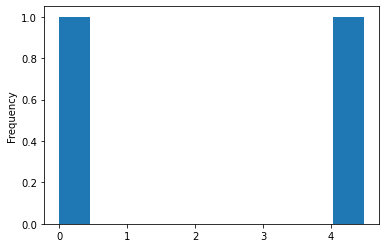

In [212]:
metrics_df.iloc[0].plot.hist()

<AxesSubplot:xlabel='MAPE', ylabel='Count'>

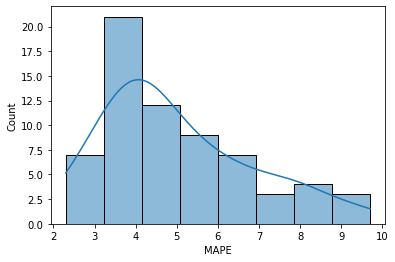

In [215]:
sns.histplot(data=metrics_df['MAPE'], kde=True)